# Анализ тональности текста (Sentiment analysis). Валидация модели

В качестве моделей будут рассматриваться рекурентные нейронные сети

In [ ]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix


warnings.filterwarnings('ignore')
np.random.seed(0)

def plot_roc_curve(y_pred, y_true) -> None:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.axis([0,1,0,1])
    plt.title("ROC-кривая")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred)}")

def plot_confusion_matrix(y_pred, y_true) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    ax.set_title("Матрица неточностей")
    ax.set_xlabel("Предсказанные значения")
    ax.set_ylabel("Действительные значения")
    plt.show()

def plot_history_nn(history) -> None:
    plt.plot(history.history['accuracy'], label="Точность на обучающем наборе")
    plt.plot(history.history['val_accuracy'], label="Точность на проверочном наборе")
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Точность")
    plt.legend()
    plt.show()

In [3]:
train_data = pd.read_csv("./data/clear_train_data.csv")

In [4]:
train_data.head()

,sentiment,review
0,1,stuff going moment mj started listening music ...
1,1,classic war worlds timothy hines entertaining ...
2,0,film starts manager nicholas bell giving welco...
3,0,must assumed praised film greatest filmed oper...
4,1,superbly trashy wondrously unpretentious explo...


In [5]:
train_data.shape

(25000, 2)

In [6]:
X = train_data["review"]
y = train_data["sentiment"]

## Подготовка данных для обучения

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [8]:
# разбиваем текст на токены и создаем их последовательности
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_clean = pad_sequences(tokenizer.texts_to_sequences(X))

In [9]:
# разобьем выборку на обучающую и проверочную
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.5)

In [10]:
X_train[:10]

array([[    0,     0,     0, ...,    11,     2,     5],
       [    0,     0,     0, ...,  3704,   649,  2041],
       [    0,     0,     0, ...,   457,  3592,   510],
       ...,
       [    0,     0,     0, ...,  1543, 11088,   328],
       [    0,     0,     0, ...,   346,   326,  4575],
       [    0,     0,     0, ...,  4593,     1,  9407]])

In [11]:
X_train.shape

(12500, 1416)

In [12]:
y_train.shape

(12500,)

In [13]:
X_val.shape

(12500, 1416)

## Создание и валидация моделей

In [14]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Embedding,
    LSTM,
    GRU,
    SimpleRNN,
)

### Простая рекурентная нейронная сеть

In [15]:
max_words = 100000

simple_model = Sequential()
simple_model.add(Embedding(max_words, 128))
simple_model.add(SimpleRNN(32, recurrent_dropout = 0.2))
simple_model.add(Dense(1, activation="sigmoid"))
simple_model._estimator_type = "classifier"

In [16]:
simple_model.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history = simple_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
88/88 [==============================] - 90s 1s/step - loss: 0.7021 - accuracy: 0.5067 - val_loss: 0.6839 - val_accuracy: 0.5592
Epoch 2/10
88/88 [==============================] - 89s 1s/step - loss: 0.6721 - accuracy: 0.5812 - val_loss: 0.6641 - val_accuracy: 0.6128
Epoch 3/10
88/88 [==============================] - 90s 1s/step - loss: 0.5790 - accuracy: 0.7128 - val_loss: 0.8258 - val_accuracy: 0.5304
Epoch 4/10
88/88 [==============================] - 90s 1s/step - loss: 0.4164 - accuracy: 0.8215 - val_loss: 0.6333 - val_accuracy: 0.7328
Epoch 5/10
88/88 [==============================] - 90s 1s/step - loss: 0.3201 - accuracy: 0.8690 - val_loss: 0.9609 - val_accuracy: 0.6976
Epoch 6/10
88/88 [==============================] - 90s 1s/step - loss: 0.2390 - accuracy: 0.9106 - val_loss: 0.9212 - val_accuracy: 0.7312
Epoch 7/10
88/88 [==============================] - 88s 999ms/step - loss: 0.1924 - accuracy: 0.9306 - val_loss: 0.5354 - val_accuracy: 0.8280
Epoch 8/10
88/88 

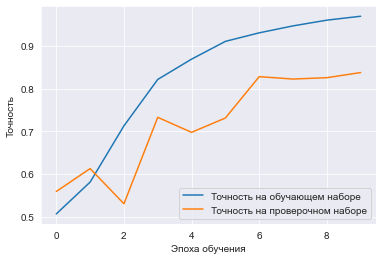

In [18]:
plot_history_nn(history)

In [19]:
y_pred = simple_model.predict(X_val)

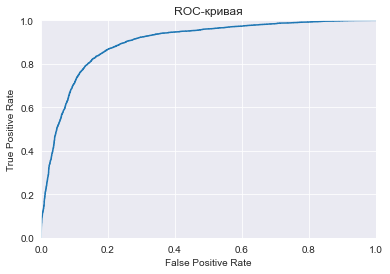

ROC-AUC Score: 0.8990642257644819


In [20]:
plot_roc_curve(y_pred, y_val)

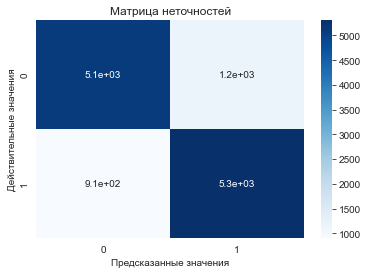

In [21]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

### Реккурентная сеть со слоем LSTM

In [22]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 128))
model_lstm.add(LSTM(32, recurrent_dropout = 0.2))
model_lstm.add(Dense(1, activation="sigmoid"))

model_lstm.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
88/88 [==============================] - 228s 3s/step - loss: 0.4839 - accuracy: 0.7765 - val_loss: 0.3393 - val_accuracy: 0.8544
Epoch 2/10
88/88 [==============================] - 225s 3s/step - loss: 0.2091 - accuracy: 0.9244 - val_loss: 0.3337 - val_accuracy: 0.8696
Epoch 3/10
88/88 [==============================] - 226s 3s/step - loss: 0.1116 - accuracy: 0.9636 - val_loss: 0.3602 - val_accuracy: 0.8584
Epoch 4/10
88/88 [==============================] - 227s 3s/step - loss: 0.0588 - accuracy: 0.9812 - val_loss: 0.4066 - val_accuracy: 0.8544
Epoch 5/10
88/88 [==============================] - 225s 3s/step - loss: 0.0356 - accuracy: 0.9901 - val_loss: 0.4922 - val_accuracy: 0.8624
Epoch 6/10
88/88 [==============================] - 226s 3s/step - loss: 0.0191 - accuracy: 0.9957 - val_loss: 0.5628 - val_accuracy: 0.8560
Epoch 7/10
88/88 [==============================] - 228s 3s/step - loss: 0.0119 - accuracy: 0.9972 - val_loss: 0.7446 - val_accuracy: 0.8576
Epoch 8/10
88

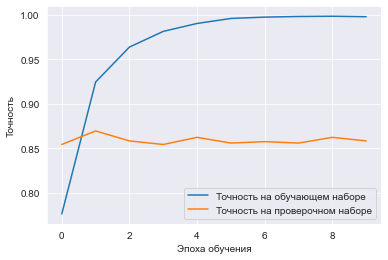

In [24]:
plot_history_nn(history)

In [25]:
y_pred = model_lstm.predict(X_val)

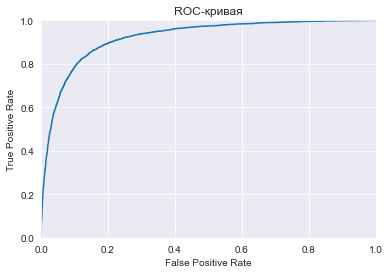

ROC-AUC Score: 0.9218223481547424


In [26]:
plot_roc_curve(y_pred, y_val)

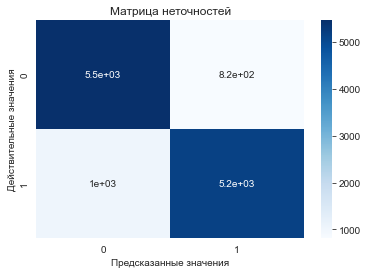

In [27]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

### Реккурентная сеть со слоем GRU

In [28]:
model_gru = Sequential()
model_gru.add(Embedding(max_words, 128))
model_gru.add(GRU(32, recurrent_dropout = 0.2))
model_gru.add(Dense(1, activation="sigmoid"))

model_gru.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history = model_gru.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
88/88 [==============================] - 202s 2s/step - loss: 0.5181 - accuracy: 0.7404 - val_loss: 0.3647 - val_accuracy: 0.8456
Epoch 2/10
88/88 [==============================] - 166s 2s/step - loss: 0.2377 - accuracy: 0.9087 - val_loss: 0.3642 - val_accuracy: 0.8608
Epoch 3/10
88/88 [==============================] - 167s 2s/step - loss: 0.1323 - accuracy: 0.9571 - val_loss: 0.4390 - val_accuracy: 0.8440
Epoch 4/10
88/88 [==============================] - 169s 2s/step - loss: 0.0789 - accuracy: 0.9744 - val_loss: 0.4374 - val_accuracy: 0.8592
Epoch 5/10
88/88 [==============================] - 172s 2s/step - loss: 0.0440 - accuracy: 0.9869 - val_loss: 0.5282 - val_accuracy: 0.8496
Epoch 6/10
88/88 [==============================] - 170s 2s/step - loss: 0.0258 - accuracy: 0.9924 - val_loss: 0.6177 - val_accuracy: 0.8632
Epoch 7/10
88/88 [==============================] - 165s 2s/step - loss: 0.0173 - accuracy: 0.9948 - val_loss: 0.6738 - val_accuracy: 0.8496
Epoch 8/10
88

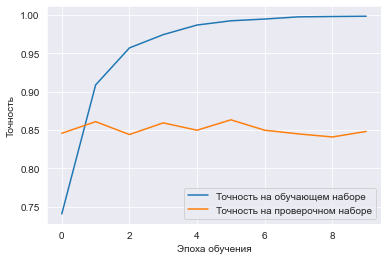

In [30]:
plot_history_nn(history)

In [31]:
y_pred = model_gru.predict(X_val)

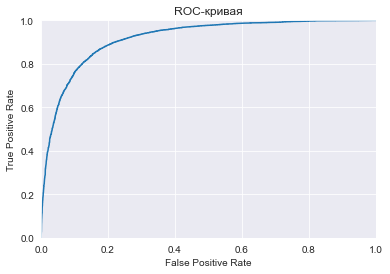

ROC-AUC Score: 0.9179701299483622


In [32]:
plot_roc_curve(y_pred, y_val)

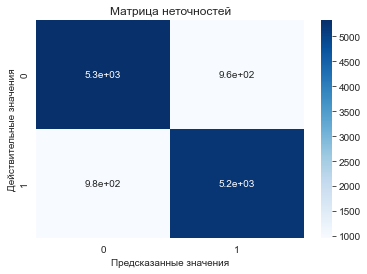

In [33]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

## Примеры

In [37]:
sample_data = train_data.sample(10)
X_sample = sample_data["review"]
X_sample = pad_sequences(tokenizer.texts_to_sequences(X_sample))

In [40]:
y_simple_rnn = simple_model.predict(X_sample)
y_gru = model_gru.predict(X_sample)
y_lstm = model_lstm.predict(X_sample)

In [52]:
data = {
    "review": sample_data["review"].to_list(),
    "true_prediction": sample_data["sentiment"].to_list(),
    "simple_rnn_prediction": [value[0] for value in y_simple_rnn],
    "gru_prediction": [value[0] for value in y_gru],
    "lstm_prediction": [value[0] for value in y_lstm],
}

In [54]:
pd.DataFrame(data)

,review,true_prediction,simple_rnn_prediction,gru_prediction,lstm_prediction
0,saw film last night following lot good reviews...,0,0.005363,0.000447,0.000179
1,never heard larry fessenden judging effort wri...,0,0.048597,0.000035,0.000124
2,one movies way better turned dread think block...,0,0.858937,0.000197,0.000327
3,cabinet dr caligari father horror films german...,1,0.117182,0.995627,0.996033
4,okay hell kind trash watching witches mountain...,0,0.195371,0.000510,0.000086
5,way confront zabriskie point rational standpoi...,1,0.998238,0.999901,0.686830
6,trying track film googling bad phrases teenage...,0,0.032239,0.000886,0.000143
7,wanting make holmes doors pun quite string tog...,0,0.003139,0.000029,0.000075
8,movie tired yet weirdly childish clich nazi wi...,0,0.002434,0.000019,0.000098
9,seen miracles still happen least four times ne...,1,0.996378,0.999995,0.999910
